In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv
/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [2]:
import pandas as pd
import numpy as np
import nltk
import spacy
import re
from keras.layers import Dense,LSTM,TextVectorization,Embedding,BatchNormalization,Input,Conv1D,MaxPool1D,Flatten,Dropout
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import AUC
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from functools import partial
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report
from tensorflow.keras.preprocessing import sequence,text
from pathlib import Path
plt.style.use("ggplot")
cmap = mpl.colormaps['coolwarm']

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def getDevice():
    gpus = tf.config.list_logical_devices('GPU')
    ngpu = len(gpus)
    # Check number of GPUs
    if ngpu:
        # Set GPU strategy
        strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
        # Print GPU details
        print("> Running on GPU", end=' | ')
        print("Num of GPUs: ", ngpu)
        device='GPU'
    else:
        # If no GPUs are available, use CPU
        print("> Running on CPU")
        strategy = tf.distribute.get_strategy()
        device='CPU'
    return strategy, device

In [4]:
class CFG():
    ml = 0
    dl = 1
    class_names = ["Human","AI"]
    num_classes = 2
    classes = list(range(num_classes))
    class_2_name = dict(zip(classes,class_names))
    num_folds = 5
    seed = 42
    max_sequence = 250
#     max_tokens = 20000    
    max_tokens = 35000
    batch_size = 32
    selected_folds = [0,1,3]
    ml_lr = 0.00001
    embd_dim = 150
    epochs = 3
    prediction_strategy = dl
    strategy, device = getDevice()
    tf.random.set_seed(seed)

> Running on GPU | Num of GPUs:  1


In [5]:
ext_data_path = Path("/kaggle/input/daigt-proper-train-dataset")
train_path = Path("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
test_path = Path('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')

In [6]:
# df = pd.read_csv(str(train_data_path))
df = pd.read_csv(str(train_path))
test_df = pd.read_csv(str(test_path))

data_frames = []
for file_path in ext_data_path.iterdir():
    if file_path.is_file():
        temp_df = pd.read_csv(file_path)
        data_frames.append(temp_df)
    
new_df = pd.concat(data_frames)
test_df.info()
# df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes


In [7]:
# total_word = set()
# for essay in df["text"]:
#     words = [word for word in essay.split(" ")]
#     total_word.update(words)
# print(len(total_word))

In [8]:
new_df["label_name"] = new_df["label"].map(CFG.class_2_name)

In [9]:
test_label_counts = new_df["label_name"].value_counts()
test_label_counts

label_name
Human    115372
AI        44084
Name: count, dtype: int64

In [10]:
new_df.groupby(["fold","label_name"]).size()

fold  label_name
0     AI             5138
      Human         14135
1     AI             5137
      Human         14136
2     AI             5136
      Human         14137
3     AI             5135
      Human         14138
4     AI             5133
      Human         14139
5     AI             3681
      Human          8939
6     AI             3680
      Human          8938
7     AI             3680
      Human          8938
8     AI             3682
      Human          8936
9     AI             3682
      Human          8936
dtype: int64

In [11]:
########### Testing with larger data
#test_df = new_df

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes


## EDA of the data

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   label          44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


In [14]:
df["label_name"] = df["label"].map(CFG.class_2_name)
label_counts = df["label_name"].value_counts()
label_counts

label_name
Human    27371
AI       17497
Name: count, dtype: int64

Text(0.5, 1.0, 'Label distribution')

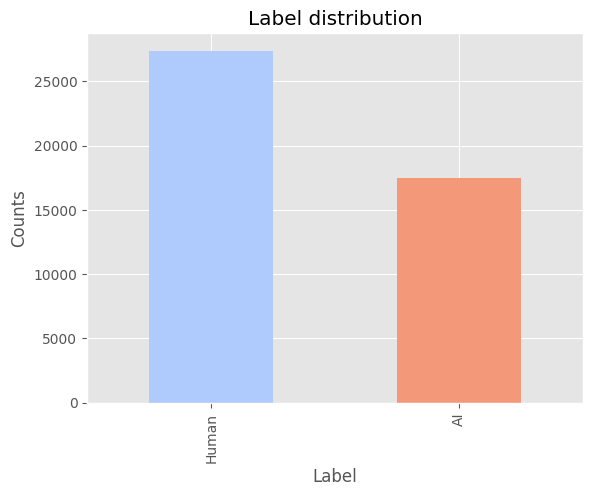

In [15]:
label_counts.plot(kind="bar",color=[cmap(0.35),cmap(0.75)])
plt.xlabel("Label")
plt.ylabel("Counts")
plt.title("Label distribution")

Text(0.5, 1.0, 'Essay Length Box Plot')

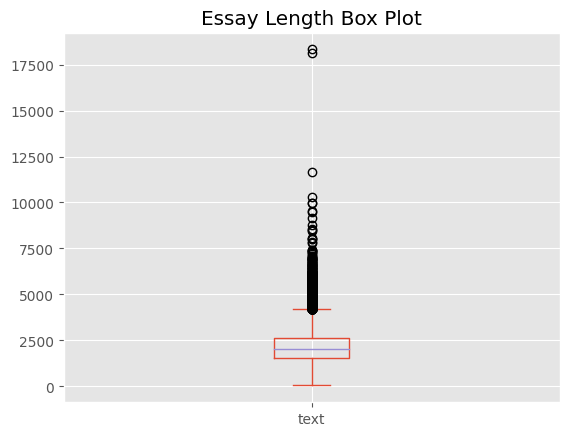

In [16]:
df["text"].str.len().plot.box()
plt.title("Essay Length Box Plot")

## Data Split

In [17]:
# Create a column to indicate the source and label combination
df["stratify"] = df["label"].astype(str) + df["source"].astype(str)
df["fold"] = 0
df.head(3)

,text,label,prompt_name,source,RDizzl3_seven,label_name,stratify,fold
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,Human,0persuade_corpus,0
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,Human,0persuade_corpus,0
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,Human,0persuade_corpus,0


In [18]:
# Create folds for the combination of label and source
skf = StratifiedKFold(n_splits=CFG.num_folds,random_state=CFG.seed,shuffle=True)

for fold, (train_inx,valid_inx) in enumerate(skf.split(df,df["stratify"])):
  df.loc[valid_inx,"fold"] = fold
df.head(3)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


,text,label,prompt_name,source,RDizzl3_seven,label_name,stratify,fold
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,Human,0persuade_corpus,2
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,Human,0persuade_corpus,4
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,Human,0persuade_corpus,0


In [19]:
df.groupby(["fold","label_name","source"]).size()

fold  label_name  source                         
0     AI          NousResearch/Llama-2-7b-chat-hf      80
                  chat_gpt_moth                       484
                  cohere-command                       70
                  darragh_claude_v6                   200
                  darragh_claude_v7                   200
                                                     ... 
4     AI          palm-text-bison1                     70
                  radek_500                           100
                  radekgpt4                            40
      Human       persuade_corpus                    5199
                  train_essays                        275
Length: 88, dtype: int64

## Preprocessing

In [20]:
# character exclusion
human_df = df[df["label_name"] == "Human"].copy()
ai_df = df[df["label_name"] == "AI"].copy()
human_characters = set("".join(human_df["text"].to_list()))
ai_characters = set("".join(ai_df["text"].to_list()))
caracter_exclusion = "".join([x for x in ai_characters if x not in human_characters])
print(caracter_exclusion)
caracter_escape = re.escape(caracter_exclusion)
char_excl_regex = f"[{caracter_escape}]"

🚫こ🔮👏🐢😕🍞👦注🍕🤪👂😋📺🍟😴—🐾🚭安🧽🌈🔧💆🏞路😅☹🐱🤯р🚴😒🌻🧡🏈’🕰🌱🎵🧖🧘👻🎩😓🧬唯🔜🐰💕👬😝🌧📰が者п💊😻📷🏔📈🥛用🏊😠📅📧🙀📸🔭🎠🌎💘🌊😤🏡🌮🙏🥳🧚📱”📄合💥ã司💫🇷🏻о🇵♂🏜🗳🌠😭🚪有🐻…🏳📣🐭机


In [21]:
exclude = re.compile("["
    u"\u000A"                 # new-line
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002500-\U00002BEF"  # chinese char
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  # dingbats
    u"\u3030"
                  "]+",re.UNICODE)
regex_pattern = exclude.pattern
html_exclude = re.compile(r'<.*?>')

def standardizeDataFrameText(text):
    if CFG.prediction_strategy == CFG.ml:
        text = re.sub(exclude,"",text)
        text = re.sub(html_exclude,"",text)
        return text



In [22]:
def standardizeText(input_data):
    if CFG.prediction_strategy == CFG.dl:
        data = tf.strings.lower(input_data)
        data = tf.strings.regex_replace(data,regex_pattern,"")
        data = tf.strings.regex_replace(data,'<.*?>',"")        
        data = tf.strings.regex_replace(data,char_excl_regex,"")

        return data

# Preprocessing and vectorization of text
def buildVectorizationLayer(texts:pd.DataFrame):
    if CFG.prediction_strategy == CFG.dl:
        vectorization_layer = TextVectorization(standardize= standardizeText,max_tokens=CFG.max_tokens,\
                                        output_mode = "int"
                                        ,output_sequence_length=CFG.max_sequence)
        train_text = tf.data.Dataset.from_tensor_slices(texts)
        vectorization_layer.adapt(train_text)
        return vectorization_layer

## Dataloader

In [23]:
def prepText(texts, tokenizer, max_sequence_length):
    if CFG.prediction_strategy == CFG.ml:
        text_sequences = tokenizer.texts_to_sequences(texts)
        return sequence.pad_sequences(text_sequences, maxlen=max_sequence_length)

def getTokenizer(texts:pd.DataFrame):
    if CFG.prediction_strategy == CFG.ml:
        texts = texts.apply(standardizeDataFrameText)
        tokenizer = text.Tokenizer(num_words = CFG.max_tokens,lower=True,)
        tokenizer.fit_on_texts(texts)
        return tokenizer

def vectorizeDataFrame(texts:pd.DataFrame,labels,tokenizer):
    if CFG.prediction_strategy == CFG.ml:
        texts = prepText(texts,tokenizer,CFG.max_sequence)
        texts = np.c_[texts,labels.to_numpy()] if labels is not None else texts
        return texts

def buildDataset(texts,labels=None,batch_size=32,shuffle=False,
                 drop_remainder=True,repeat=False,vectorizer=None):
    AUTO = tf.data.AUTOTUNE
    slices = (texts) if labels is None else (texts,labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    # ds = ds.cache() if cache else ds
    # Vectorization function
    def vectorizeText(texts,labels=None):
        texts = vectorizer(texts)
        return (texts) if labels is None else (texts,labels)

    ds = ds.map(vectorizeText, num_parallel_calls=AUTO)

    ds = ds.repeat() if repeat else ds
    opt = tf.data.Options()
    if shuffle:
        ds = ds.shuffle(shuffle,seed=CFG.seed)
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)
    ds = ds.batch(batch_size,drop_remainder = drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds


def getDataset(fold=None,test=False,df=None,vectorizer=None):
   
    if test == False: # create training and validation set
        # Create the training dataset
        train_df = df[df["fold"]!= fold].sample(frac=1)
        train_text = train_df["text"].to_list()
        train_labels = train_df["label"].to_list()
        
        # Vectorize the text based on training data
        vectorizer = buildVectorizationLayer(train_text) # Create the vectorization layer
        tokenizer  = getTokenizer(train_df["text"])      # Tokenizer from training data

        train_ds = buildDataset(train_text,train_labels,
                            batch_size=CFG.batch_size,shuffle=True,
                            drop_remainder=True,repeat=True,vectorizer=vectorizer)
        # Vectorized dataframe

        train_np = vectorizeDataFrame(train_df["text"],train_df["label"],tokenizer=tokenizer)


        # Create the validation dataset
        
        valid_df = df[df["fold"]==fold].sample(frac=1)
        valid_text = valid_df["text"].to_list()
        valid_labels = valid_df["label"].to_list()

        valid_ds = buildDataset(valid_text,valid_labels,
                            batch_size=CFG.batch_size,shuffle=False,
                            drop_remainder=True,repeat=False,vectorizer=vectorizer)
        # Vectorized dataframe
        valid_np = vectorizeDataFrame(valid_df["text"],valid_df["label"],tokenizer=tokenizer)

        return (train_ds,train_df,train_np),(valid_ds,valid_df,valid_np),vectorizer
    else: # Create test data set
        if vectorizer is not None:
            test_text = df["text"].to_list()
            # Vectorize the text based on training data
    #         vectorizer = buildVectorizationLayer(test_text) # Create the vectorization layer
            test_ds = buildDataset(test_text,None,
                        batch_size=CFG.batch_size,shuffle=False,
                        drop_remainder=False,repeat=False,vectorizer=vectorizer)
            return test_ds

In [24]:
def getMlModels():
    classifiers = {}
    # xgb = XGBClassifier(learning_rate= CFG.ml_lr,n_estimators=300,
    #                     objective= 'binary:logistic',seed=CFG.seed)
    # classifiers["xgb"] = xgb
    lr = LogisticRegression(random_state=CFG.seed,verbose = 1)
    classifiers["lr"] = lr
    rfc = RandomForestClassifier(verbose=2,random_state=CFG.seed,n_estimators=200)
    classifiers["rfc"] = rfc
    # adgc = AdaBoostClassifier(learning_rate=CFG.ml_lr)
    # classifiers["adgc"] = adgc
    # svc = SVC(verbose=True,random_state = CFG.seed)
    # classifiers["svc"] = svc
    return classifiers

def trainMlModels(classifiers,train_feat,train_label,valid_feat,valid_label):
    for item in classifiers.items():
        print("="*20)
        print(f"\t Model :{item[0]}")
        classifier = item[1]
        classifier.fit(train_feat,train_label.ravel())
        predictions = classifier.predict(valid_feat)
        auc = roc_auc_score(valid_label,predictions)
        confusion = confusion_matrix(valid_label,predictions)
        classification_rep = classification_report(valid_label,predictions)
        print(f"\t AUC = {auc}")
        print(f"\t Confusin Matrix{item[0]}: \n{confusion}")
        print(f"\t Classification Report {item[0]}: \n{classification_rep}")
        print("="*20)

def trainMlFolds():
    if CFG.prediction_strategy == CFG.ml:
        for fold in CFG.selected_folds:
            print(f">"*30)
            print(f"Fold {fold}")
            (t_ds,t_df,t_np),(v_ds,v_df,v_np) = getDataset(fold)
            train_feat = t_np[:,:-1]
            train_label = t_np[:,-1:]
            valid_feat = v_np[:,:-1]
            valid_label = v_np[:,-1:]
            classifiers = getMlModels()
            trainMlModels(classifiers,train_feat,train_label,valid_feat,valid_label)
            print(f">"*30)

In [25]:
# def buildDLModel():
#     model = Sequential()
#     model.add(Embedding(input_dim=CFG.max_tokens,output_dim=CFG.embd_dim,input_shape=(CFG.max_sequence,)))
#     model.add(LSTM(100,recurrent_dropout=0.2))
#     # model.add(LSTM(50))
#     model.add(Dense(1,activation="sigmoid"))
#     model.summary()
#     model.compile(optimizer= Adam(),loss=binary_crossentropy,metrics=[AUC(name="auc")])
#     return model
# def Dl0():
#     model = Sequential()
#     model.add(Embedding(input_dim=CFG.max_tokens,output_dim=CFG.embd_dim,input_shape=(CFG.max_sequence,)))
#     model.add(LSTM(100,recurrent_dropout=0.2,return_sequences=True))
#     model.add(LSTM(50))
#     model.add(Dense(1,activation="sigmoid"))
#     model.summary()
#     model.compile(optimizer= Adam(),loss=binary_crossentropy,metrics=[AUC(name="auc")])
#     return model
# def DL1():
#     model = Sequential()
#     model.add(Embedding(input_dim=CFG.max_tokens,output_dim=CFG.embd_dim,input_shape=(CFG.max_sequence,)))
#     model.add(LSTM(100,recurrent_dropout=0.2))
#     model.add(BatchNormalization())
#     model.add(Dense(1,activation="sigmoid"))
#     model.summary()
#     model.compile(optimizer= Adam(),loss=binary_crossentropy,metrics=[AUC(name="auc")])
#     return model
# def DL1_v2():
#     model = Sequential()
#     model.add(Embedding(input_dim=CFG.max_tokens,output_dim=250,input_shape=(CFG.max_sequence,)))
#     model.add(LSTM(100,recurrent_dropout=0.2))
#     model.add(BatchNormalization())
#     model.add(Dense(1,activation="sigmoid"))
#     model.summary()
#     model.compile(optimizer= Adam(),loss=binary_crossentropy,metrics=[AUC(name="auc")])
#     return model
# def DL2():
#     model = Sequential()
#     model.add(Embedding(input_dim=CFG.max_tokens,output_dim=50,input_shape=(CFG.max_sequence,)))
#     model.add(LSTM(50,recurrent_dropout=0.2))
#     model.add(BatchNormalization())
#     model.add(Dense(1,activation="sigmoid"))
#     model.summary()
#     model.compile(optimizer= Adam(),loss=binary_crossentropy,metrics=[AUC(name="auc")])
#     return model

def temporal_conv():
    inp = Input(shape=(CFG.max_sequence,))
    embed = Embedding(input_dim=CFG.max_tokens,output_dim=CFG.embd_dim,input_shape=(CFG.max_sequence,))(inp)
    conv1d = Conv1D(filters=264,kernel_size =5,activation="relu")(embed)
    maxpool = MaxPool1D(pool_size =2,strides =2)(conv1d)
    lstm = LSTM(128)(maxpool)
#     lstm2 = LSTM(64)(lstm)    
    flatten = Flatten()(lstm)
    drop = Dropout(0.3)(flatten)
    dense = Dense(10,activation="relu")(drop)
    out = Dense(1,activation="sigmoid")(dense)
    model = Model(inputs=inp,outputs=out)
    model.summary()
    model.compile(optimizer= Adam(),loss=binary_crossentropy,metrics=[AUC(name="auc")])
    return model
    
    

In [26]:
(t_ds,t_df,t_np),(v_ds,v_df,v_np),vectorizer = getDataset(1,False,df)

In [27]:
scores = []

In [28]:
with CFG.strategy.scope():
    if CFG.prediction_strategy == CFG.dl:
#         model = DL1()
#         model = DL1_v2()
        # model = buildDLModel()
#         model = DL2()
#         model = Dl0()
        model = temporal_conv()


        model.fit(t_ds,epochs=CFG.epochs,validation_data=v_ds,
                steps_per_epoch= (len(t_df) // CFG.batch_size),
                validation_steps=(len(v_df) // CFG.batch_size ))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 150)          5250000   
                                                                 
 conv1d (Conv1D)             (None, 246, 264)          198264    
                                                                 
 max_pooling1d (MaxPooling1  (None, 123, 264)          0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 128)               201216    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                             

In [29]:
test_ds  = getDataset(None,True,test_df,vectorizer)

In [30]:
def getPredictions(ds):
    predictions = model.predict(ds,batch_size= min(CFG.batch_size,len(test_df)),)
    return predictions.squeeze()

In [31]:
model_predictions = getPredictions(test_ds)



1/1 [==============================] - 1s 752ms/step


In [32]:
# def saveWeights(weight_name):
#     weights_path = Path("/kaggle/working/weights")
#     weights_path = weights_path / weight_name
#     test_dl_2.save_weights(weights_path)

In [33]:
name = "temporal_conv15_lstm"
config = model.summary()
name,config

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 150)          5250000   
                                                                 
 conv1d (Conv1D)             (None, 246, 264)          198264    
                                                                 
 max_pooling1d (MaxPooling1  (None, 123, 264)          0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 128)               201216    
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                             

('temporal_conv15_lstm', None)

In [34]:
# def getRocScore():
#     roc_score1 = roc_auc_score(test_df[["label"]].to_numpy().squeeze(),model_predictions.flatten())
#     print(roc_score1)
#     score = {"name":name,"config":config,"score":roc_score1}
#     scores.append(score)

In [35]:
# test_df.info()

In [36]:
# getRocScore()

In [37]:
# saveWeights("em150Lstm100Lstm50bd1")

In [38]:
submissions = test_df[["id"]].copy()
submissions["generated"] = getPredictions(test_ds)
submissions.to_csv("submission.csv",index=False)

1/1 [==============================] - 0s 227ms/step


In [39]:
submissions.head(3)

,id,generated
0,0000aaaa,0.783344
1,1111bbbb,0.785571
2,2222cccc,0.785571
